In [ ]:
# Week 2 Optimization Problems and Rydberg Atom Arrays
### Team 8 Alex Khan, Theo Cleland,  Henry Makhanov, Ehsan Torabizadeh, Darshit Mehta

## This notebook contains:
### A. Task 3 - Execution of a Real Problem - City of Gotham
### B. Additional Challenges:
#### (b) Benchmark other classical and quantum optimization methods 
#### (d) Perform any of the tasks with real quantum hardware

## A. Task 3 - Execution of a Real Problem - City of Gotham  and 
## B. Additional Challenges (d) D-Wave

### 1. Why this problem can be mapped easily to the UD-MIS problem?

The requirements of the problem to maximize the tower coverage (use as many nodes as possible) 
and that the signal range not overlap (penalize node pairs with some condition) fits the UD-MIS formulation

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

### 2. Solve Gotham City problem (see execution below)

Solution graph below shows one of the solutions.

<img src="./resources/image b21.png" width="300" align="center">

**Using D-Wave**: There are multiple solutions with the same lowest energy as indicated by this table:

<img src="./resources/image b22.png" width="300" align="center">

All these solutions were found using D-Wave and all have the lowest energy of -5. A '1' indicates the vertex which is occupied.

The lowest energy solutions are shown in the gif below:
    
<img src="./resources/Gotham Solutions 1.gif" width="300" align="center">

### 3. Should Bruce pay for a few more cell towers?

No. As the full set of solutions show, we can have from 5 to 7 towers and still have the lowest energy of -5. 

Adding an additional tower will add to the capital cost of adding a tower, however, there is no additional benefit 
based on the current formuation.

We would have to do an marginal analsysis and look at the incremental cost of each additional tower and
compare to the incremental coverage area for adding the additional tower.

With the current threshold based binary UD-MIS formulation it is  not possible to get this level of information.

In the "Additional Challenges" - running on a quantum computer.  We will change this formulation to have a Quadratic Binary
model where the incremental energy of each position and number of towers become more available to us for analysis.

## B. Additional Challenges (b) Repeated runs on Microsoft QIO
Repeated runs on Microsoft QIO gave the same answer:
    
[0, 3, 4, 8, 9]

This solver (similar to most simulated annealing solvers) seems to give only one answer, and also, we did not
see the value changing, so it did not appear to be probabilistic.

We showed that we can use another solver, however, we have not shown benchmark results.

## B. Additional Challenges (d) Perform any task on a quantum computer

We execute the Gotham solution UD-MIS formulation on D-Wave quantum annealer.

The embedding is shown as:
    
<img src="./resources/image b41.png" width="300" align="center">   

The energy values from D-Wave are shown in the plot below:

<img src="./resources/image b43.png" width="300" align="center">

The table of results from run 2 is shown below:

<img src="./resources/image b44.png" width="300" align="center">

This solution is similar to that found using the classical solution.

However, the UD-MIS formulation where the range overlap is descretized does not give solutions that would
indicate the optimum solution since a large overlap and a small overlap both have the same penalty (higher energy of +1).

Thus a **modified solution** is found with a different solver (D-Wave) which uses the equation:

$$ f(x) = \sum_{i} {Q_{i,i}}{x_i} + \sum_{i<j} {Q_{i,j}}{x_i}{x_j} $$

As can be seen, in this solver the coefficient $Q_{i,j}$ can be used to indicate higher penalty for higher overlap.

We will use $Q_{i,j}=1/D_{ij}$
We also use the energy of each tower as -3 

Using this formula and the execution below, we get the following best energy solution of -9.513712 using **D-Wave**. (note this solution was only found 1 time with 100 samples)

<img src="./resources/image b31.png" width="300" align="center">

A sampling of other solutions is given below:

<img src="./resources/image b32.png" width="300" align="center">

The gif starts with the lowest energy and progresses up.  The subtle placement is more apparent in this solution. Also we do not see towers showing up too close to each other eg. 7 and 8:

<img src="./resources/Gotham Solutions 2.gif" width="300" align="center">

This concludes the analysis of running the modified Gotham formulation on D-Wave. We find that even with this formulation,
the ideal number of towers is 5, however, we can see that there are solutions with slightly less coverage that require
only 4 towers. Thus the incremental value of each configuration is more apparent and the incremental value of adding
a tower for a marginal cost can also be found. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from abstract_udmis import AbstractUDMIS

%matplotlib inline

In [12]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    
                    edges[i,j] = True
                    edges[j,i] = True
                    
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

In [13]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


In [6]:
print(udmis.num_vertices)
print(udmis.occupations)
print(udmis.edges)

6
[ True False False False False  True]
[[False False False  True False  True]
 [False False  True False  True False]
 [False  True False False False False]
 [ True False False False False  True]
 [False  True False False False False]
 [ True False False  True False False]]


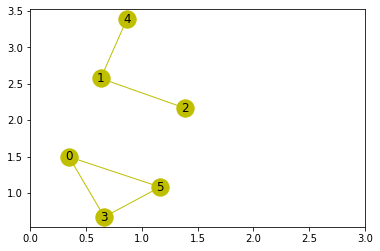

In [18]:
def make_plot(udmis, graph, solution=None):
    fig, ax = plt.subplots()

    G=nx.Graph()

    for i in range(udmis.num_vertices):

        G.add_node(i,pos=(graph[i][0],graph[i][1]))

    edge_list=[]
    for i in range(udmis.num_vertices):
        for j in range(i+1,udmis.num_vertices):
            if udmis.edges[i,j]==True:
                G.add_edge(i,j)
                edge_list.append([i,j])
    pos=nx.get_node_attributes(G,'pos')

    node_color=[]
    if (solution is not None):
        node_color = ['g' if sol == 1 else 'y' for sol in solution]
    else: 
        node_color = 'y'

    #nx.draw_networkx_nodes(G, pos, ax=ax, node_color='y')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_color)


    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='y')

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.xlim([0, 3.0])
    plt.xlim([0, 3.0])
    plt.show()

make_plot(udmis, graph)

In [15]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    
    if t % 100 == 0:
        print(t, E, udmis.occupations)

0 -1.0 [False False False False  True False]
100 -1.65 [ True False  True False False  True]
200 -1.2999999999999998 [ True  True  True False False  True]
300 -1.2999999999999998 [ True  True False False  True  True]
400 -1.65 [False False  True  True False  True]
500 -3.0 [ True False  True False  True False]
600 -1.65 [ True  True  True False False False]
700 -1.2999999999999998 [ True  True False  True  True False]
800 -2.0 [ True False False False  True False]
900 0.050000000000000266 [ True False False  True  True  True]
1000 0.050000000000000266 [ True  True False  True False  True]
1100 0.7500000000000004 [ True  True  True  True  True  True]
1200 -2.0 [False  True False False False  True]
1300 -1.65 [ True False False  True  True False]
1400 -2.0 [ True False False False  True False]
1500 -2.0 [ True False  True False False False]
1600 -3.0 [False False  True  True  True False]
1700 -3.0 [False False  True  True  True False]
1800 -0.6499999999999999 [ True False False False Fal

In [16]:
print(udmis.occupations)

[ True False  True False  True False]


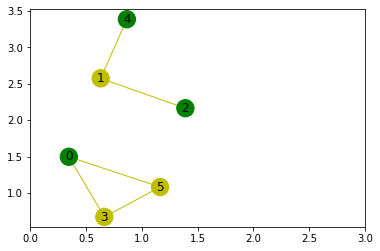

In [19]:
make_plot(udmis, graph, udmis.occupations)

## A. Task 3 - Execution of a Real Problem - City of Gotham

In [20]:
u = 1.35
graph = [(1.19, 4.25), 
         (2.71, 3.48), 
         (1.19, 3.51), 
         (2, 3.38), 
         (1.12, 2.86), 
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15,1.54),
         (2.14,1.87),
         (1.72,0.86),
         (2.29,0.87),
        ]

udmis = UDMIS(u, graph)

12


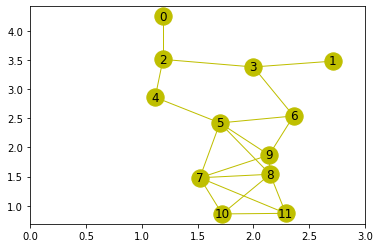

In [52]:
make_plot(udmis, graph)

In [21]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    
    if t % 100 == 0:
        print(t, E, udmis.occupations)

0 -2.3 [False  True  True False  True False False False  True False False  True]
100 1.4500000000000006 [False  True  True False  True  True  True False  True False  True  True]
200 -0.5999999999999979 [False False  True  True  True False  True  True False False  True False]
300 -0.2499999999999991 [ True False False  True  True False False  True  True  True  True False]
400 4.1000000000000005 [False False False False False False False  True  True False  True  True]
500 3.8000000000000025 [False False  True False  True  True  True  True  True False  True False]
600 -0.9499999999999997 [False False  True False False  True  True False  True False  True False]
700 -1.5999999999999992 [ True  True False  True  True False False  True  True False  True False]
800 0.75 [ True False False False  True  True False  True False  True  True False]
900 0.7500000000000009 [False False  True  True  True  True False False  True False  True False]
1000 -0.24999999999999956 [ True  True  True False False

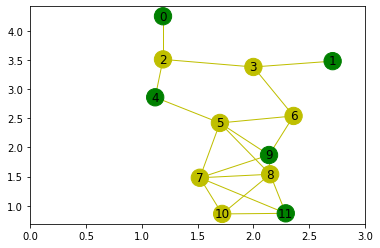

In [24]:
make_plot(udmis, graph, udmis.occupations)

We see the optimal solution of Gotham based on the UD-MIS formulation

## B. Additional Challenges (d) Run on a quantum computer

#### Run Gotham formulation on D-Wave quantum annealer using UD-MIS

In [25]:
import numpy as np
from numpy.random import rand

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from minorminer import find_embedding
import networkx as nx
import dwave.inspector

In [26]:
print(udmis.edges)

[[False False  True False False False False False False False False False]
 [False False False  True False False False False False False False False]
 [ True False False  True  True False False False False False False False]
 [False  True  True False False False  True False False False False False]
 [False False  True False False  True False False False False False False]
 [False False False False  True False  True  True  True  True False False]
 [False False False  True False  True False False False  True False False]
 [False False False False False  True False False  True  True  True  True]
 [False False False False False  True False  True False  True  True  True]
 [False False False False False  True  True  True  True False False False]
 [False False False False False False False  True  True False False  True]
 [False False False False False False False  True  True False  True False]]


In [27]:
Q=np.zeros([udmis.num_vertices, udmis.num_vertices])
for i in range(udmis.num_vertices):
    for j in range(udmis.num_vertices):
        if i!=j:
            if udmis.edges[i,j]==True:
                Q[i,j]=1
        else:
            Q[i,i]=-1
print(Q)

[[-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1. -1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1. -1.]]


In [28]:
linear={(k, k):Q[k][k] for k in range(udmis.num_vertices)}

quadratic={(i, j):Q[i][j] for i in range(udmis.num_vertices) for j in range(udmis.num_vertices) if Q[i,j]>0 and j<i+1}

QDwave = dict(linear)
QDwave.update(quadratic)
print(QDwave)

{(0, 0): -1.0, (1, 1): -1.0, (2, 2): -1.0, (3, 3): -1.0, (4, 4): -1.0, (5, 5): -1.0, (6, 6): -1.0, (7, 7): -1.0, (8, 8): -1.0, (9, 9): -1.0, (10, 10): -1.0, (11, 11): -1.0, (2, 0): 1.0, (3, 1): 1.0, (3, 2): 1.0, (4, 2): 1.0, (5, 4): 1.0, (6, 3): 1.0, (6, 5): 1.0, (7, 5): 1.0, (8, 5): 1.0, (8, 7): 1.0, (9, 5): 1.0, (9, 6): 1.0, (9, 7): 1.0, (9, 8): 1.0, (10, 7): 1.0, (10, 8): 1.0, (11, 7): 1.0, (11, 8): 1.0, (11, 10): 1.0}


In [29]:
chainstrength = 2
numruns = 100
sampler = EmbeddingComposite(DWaveSampler())


response = sampler.sample_qubo(QDwave, chain_strength=chainstrength, num_reads=numruns)
print(response)
dwave.inspector.show(QDwave,response)

    0  1  2  3  4  5  6  7  8  9 10 11 energy num_oc. chain_.
0   1  1  0  0  1  0  1  0  1  0  0  1   -5.0      10     0.0
1   1  1  0  1  1  0  0  0  0  1  1  0   -5.0       2     0.0
2   1  1  0  0  1  0  0  0  0  1  1  1   -5.0       5     0.0
3   1  1  0  0  1  0  1  1  0  0  1  0   -5.0       7     0.0
4   1  1  0  0  1  0  1  0  0  0  1  1   -5.0       4     0.0
5   1  1  0  0  1  0  1  1  1  0  0  0   -5.0       7     0.0
6   1  1  0  0  1  0  1  0  0  1  0  1   -5.0       7     0.0
7   1  1  0  0  1  0  1  0  1  0  1  0   -5.0       6     0.0
8   1  1  0  0  1  0  0  0  0  1  0  1   -5.0       6     0.0
9   1  1  0  0  1  0  1  0  0  1  1  1   -5.0       9     0.0
10  1  1  0  0  1  0  1  0  0  0  0  1   -5.0       4     0.0
11  1  1  0  1  1  0  0  0  0  1  1  1   -5.0       5     0.0
12  1  1  0  0  1  0  1  0  0  0  1  0   -5.0       2     0.0
13  1  1  0  0  1  0  1  1  0  0  0  1   -5.0       5     0.0
14  1  1  0  0  1  0  1  1  0  0  0  0   -5.0       6     0.0
15  1  1

'http://127.0.0.1:18000/?problemId=d59029ec-e9f1-46f1-9427-3b1a8faf3a15'

### The figure below shows the problem graph as represented within D-Wave

Graph representation on D-Wave
<img src="./resources/image b41.png" width="300" align="center">

Embedding on D-Wave 2000Q
<img src="./resources/image b42.png" width="300" align="center">

Energy Sampled by D-Wave
<img src="./resources/image b43.png" width="300" align="center">

There are many solutions with energy -5

    0  1  2  3  4  5  6  7  8  9 10 11 energy num_oc. chain_.
0   1  1  0  0  1  0  1  0  0  1  0  1   -5.0       4     0.0
1   1  1  0  0  1  0  1  1  0  0  0  0   -5.0       4     0.0
2   1  1  0  0  1  0  1  0  0  0  1  1   -5.0       4     0.0
3   1  1  0  0  1  0  0  0  0  1  1  1   -5.0      10     0.0
4   1  0  0  1  1  0  0  0  0  1  0  1   -5.0       7     0.0
5   1  1  0  0  1  0  1  0  1  0  0  0   -5.0       1     0.0
6   1  1  0  0  1  0  1  0  0  1  1  1   -5.0       8     0.0
7   1  1  0  0  1  0  1  0  1  0  1  0   -5.0       1     0.0
8   1  1  0  1  1  0  0  0  0  1  1  1   -5.0       3     0.0
9   1  1  0  1  1  0  0  0  0  1  1  0   -5.0       1     0.0
10  1  0  0  1  1  0  0  0  0  1  1  1   -5.0       7     0.0
11  1  1  0  0  1  0  1  1  0  0  1  0   -5.0       7     0.0
12  1  1  0  1  1  0  0  0  0  1  0  1   -5.0       5     0.0
13  1  1  0  0  1  0  0  0  0  1  1  0   -5.0       4     0.0
14  1  1  0  0  1  0  1  0  0  0  1  0   -5.0       2     0.0
15  1  1  0  0  1  0  1  0  0  1  1  0   -5.0       4     0.0
16  1  0  0  1  1  0  0  0  0  1  1  0   -5.0       3     0.0
17  1  1  0  0  1  0  1  0  0  0  0  1   -5.0       4     0.0
18  1  1  0  0  1  0  1  1  0  0  0  1   -5.0      11     0.0
19  1  1  0  0  1  0  0  0  0  1  0  1   -5.0       9     0.0
20  1  1  0  0  1  0  1  0  1  0  0  1   -5.0       1     0.0

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -5.0


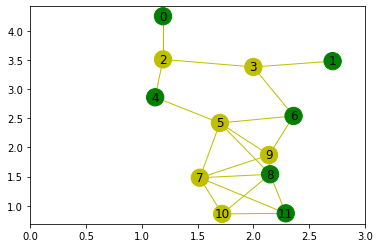

{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -5.0


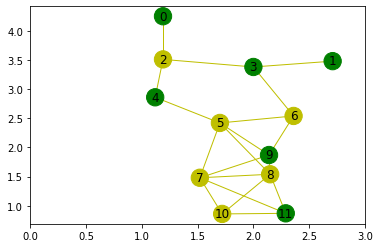

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -5.0


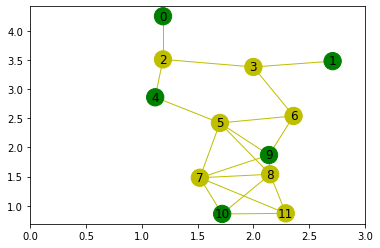

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -5.0


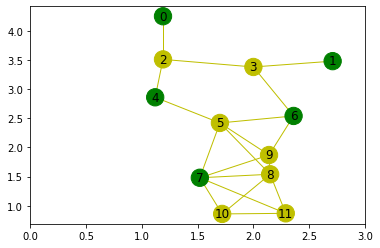

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -5.0


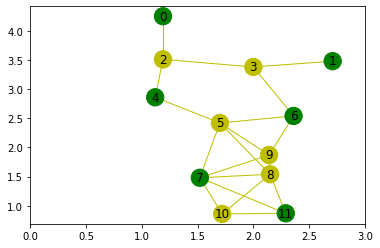

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0} -5.0


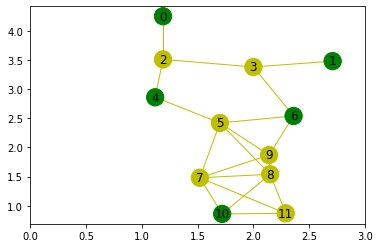

{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1} -5.0


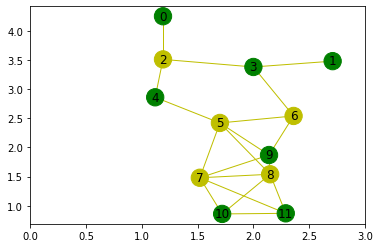

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1} -5.0


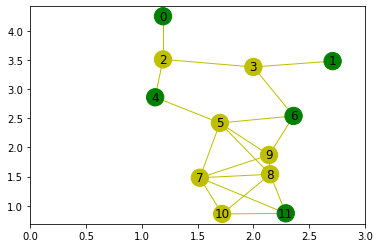

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0} -5.0


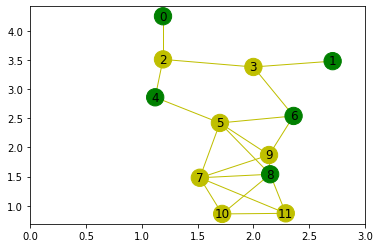

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1} -5.0


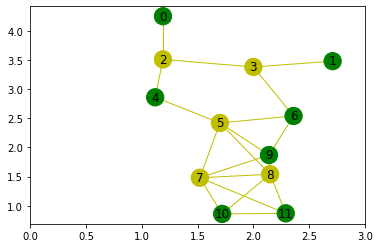

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -5.0


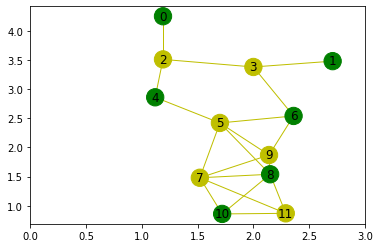

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -5.0


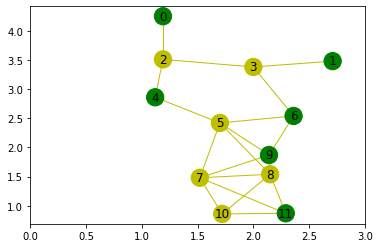

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0} -5.0


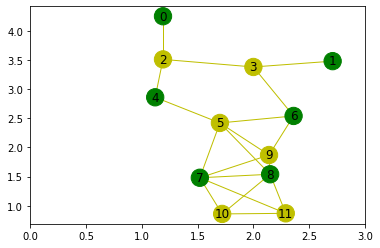

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1} -5.0


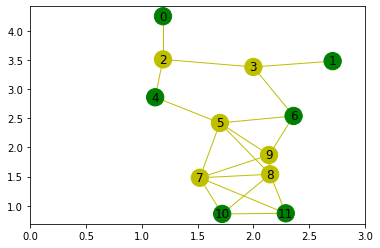

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0} -5.0


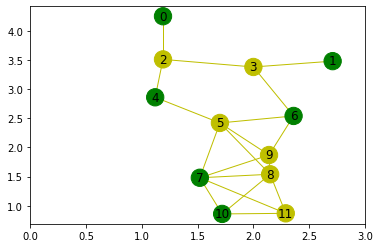

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1} -5.0


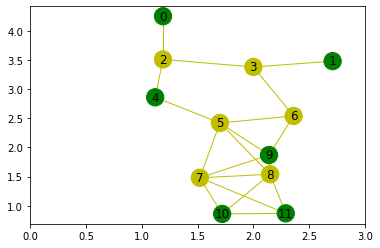

{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -5.0


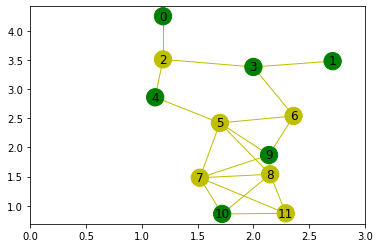

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -5.0


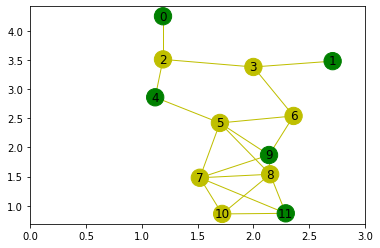

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -5.0


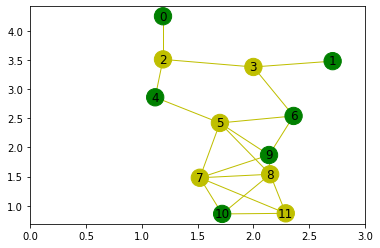

In [46]:
for sample in response.data():
    print(sample.sample, sample.energy)
    occupations = [sample.sample[sol] for sol in (sample.sample)]
    make_plot(udmis, graph, occupations)

In [ ]:
The solution from Simulated Quantum Annealing (Julia) is below:
-5.0 [ True False False  True  True False False False  True False  True]

## B. Additional Challenges (d) Run on a quantum computer

#### Run Gotham formulation on D-Wave quantum annealer with new formulation

## Now Redo the formulation with $Q_{ij}=1/D_{ij}$

dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)

In [47]:
print(graph)

[(1.19, 4.25), (2.71, 3.48), (1.19, 3.51), (2, 3.38), (1.12, 2.86), (1.7, 2.42), (2.36, 2.54), (1.52, 1.48), (2.15, 1.54), (2.14, 1.87), (1.72, 0.86), (2.29, 0.87)]


In [48]:
len_g=len(graph)
Q=np.zeros([len_g, len_g])

for i in range(len_g):
    x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
    for j in range(len_g):
        x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
        if i==j:
            Q[i,i]=-3
        else:
            # calculate the distance between vertices
            dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
            Q[i,j]=1/dij
            Q[j,i]=1/dij
print(Q)

[[-3.          0.5868864   1.35135135  0.84125744  0.71851393  0.5263887
   0.48263583  0.3584759   0.34782451  0.39022923  0.29144488  0.2813343 ]
 [ 0.5868864  -3.          0.65776664  1.39468522  0.58595874  0.68299574
   0.99696388  0.4296914   0.49524374  0.58550659  0.3570404   0.37827533]
 [ 1.35135135  0.65776664 -3.          1.21896846  1.52961714  0.83097073
   0.65798018  0.48622813  0.45631665  0.52762552  0.37003044  0.34965035]
 [ 0.84125744  1.39468522  1.21896846 -3.          0.9783256   0.99424998
   1.09422027  0.51028379  0.54168129  0.65942348  0.39439831  0.39577354]
 [ 0.71851393  0.58595874  1.52961714  0.9783256  -3.          1.37360564
   0.78086881  0.69599012  0.59726245  0.70351048  0.47891314  0.43318872]
 [ 0.5263887   0.68299574  0.83097073  0.99424998  1.37360564 -3.
   1.49071198  1.04484595  1.01175404  1.41976147  0.64097297  0.60295692]
 [ 0.48263583  0.99696388  0.65798018  1.09422027  0.78086881  1.49071198
  -3.          0.7393829   0.9786535   1.

In [49]:
linear={(k, k):Q[k][k] for k in range(udmis.num_vertices)}

quadratic={(i, j):Q[i][j] for i in range(udmis.num_vertices) for j in range(udmis.num_vertices) if Q[i,j]>0 and j<i+1}

QDwave = dict(linear)
QDwave.update(quadratic)
print(QDwave)

{(0, 0): -3.0, (1, 1): -3.0, (2, 2): -3.0, (3, 3): -3.0, (4, 4): -3.0, (5, 5): -3.0, (6, 6): -3.0, (7, 7): -3.0, (8, 8): -3.0, (9, 9): -3.0, (10, 10): -3.0, (11, 11): -3.0, (1, 0): 0.5868863963325909, (2, 0): 1.3513513513513509, (2, 1): 0.6577666351429456, (3, 0): 0.8412574418751145, (3, 1): 1.3946852184589265, (3, 2): 1.2189684577707984, (4, 0): 0.7185139255635232, (4, 1): 0.5859587353090476, (4, 2): 1.5296171388564488, (4, 3): 0.9783256002435403, (5, 0): 0.5263887015457211, (5, 1): 0.6829957417738728, (5, 2): 0.8309707336430371, (5, 3): 0.9942499771198227, (5, 4): 1.3736056394868905, (6, 0): 0.4826358252922993, (6, 1): 0.9969638831949676, (6, 2): 0.6579801795667898, (6, 3): 1.0942202738310214, (6, 4): 0.7808688094430306, (6, 5): 1.49071198499986, (7, 0): 0.3584759031545365, (7, 1): 0.4296914011771287, (7, 2): 0.48622813321711267, (7, 3): 0.510283786491363, (7, 4): 0.695990120351165, (7, 5): 1.0448459488214323, (7, 6): 0.7393829023702914, (8, 0): 0.34782450892830286, (8, 1): 0.4952437

In [50]:
chainstrength = 2
numruns = 100
sampler = EmbeddingComposite(DWaveSampler())


response = sampler.sample_qubo(QDwave, chain_strength=chainstrength, num_reads=numruns)
print(response)
dwave.inspector.show(QDwave,response)

    0  1  2  3  4  5  6  7  8  9 10 11    energy num_oc. chain_.
0   1  1  0  0  1  0  0  1  0  0  0  1 -9.513712       3     0.0
1   1  1  0  0  1  0  0  0  0  1  1  0 -9.387791       2     0.0
2   1  1  0  0  1  0  0  0  0  1  0  1  -9.34766       1     0.0
3   1  1  0  0  1  0  0  0  1  0  1  0  -9.29798       7     0.0
4   1  1  0  0  1  0  0  0  1  0  0  1 -9.114529       1     0.0
5   1  1  1  0  0  0  0  1  0  0  0  1 -9.102367       3     0.0
6   1  1  0  0  1  0  0  1  0  0  1  0 -8.962071       5     0.0
7   1  1  0  0  0  0  0  1  0  0  0  1 -8.947363       1     0.0
8   1  1  0  0  0  1  0  0  0  0  0  1 -8.941163       1     0.0
9   1  1  0  0  1  0  1  1  0  0  0  1 -8.915584       1     0.0
10  1  0  0  0  1  0  1  1  0  0  0  1 -8.893359       1     0.0
11  0  1  1  0  0  0  0  1  0  0  0  1 -8.680415       1     0.0
12  1  0  0  1  0  0  1  1  0  0  0  1 -8.680386       2     0.0
13  1  1  0  0  1  0  0  0  1  0  0  0  -8.66831       2     0.0
14  1  0  0  1  1  0  0  

'http://127.0.0.1:18000/?problemId=3eab6ce4-bdaa-445a-8f05-3d78bb1213db'

Since this is a full graph (not just edges based on a threshold), D-Wave draws the following graph

![Dwave Graph](./resources/task3-2-dwave-graph.png)

The embedding on the qubits is shown as 

![image-3.png](./resources/task3-2-dwave-embeddings.png)

The energy spectrum is given by 

![image-2.png](./resources/task3-2-dwave-energy-spectrum.png)

In [ ]:
    0  1  2  3  4  5  6  7  8  9 10 11    energy num_oc. chain_.
0   1  1  0  0  1  0  0  1  0  0  0  1 -9.513712       1     0.0
1   1  1  0  0  1  0  0  0  0  1  1  0 -9.387791       1     0.0
2   1  1  0  0  1  0  0  0  0  1  0  1  -9.34766       2     0.0
3   1  1  0  0  1  0  0  0  1  0  1  0  -9.29798       1     0.0
4   1  1  0  0  1  0  1  0  0  0  0  1 -9.157097       2     0.0
5   1  1  0  0  1  0  0  0  0  0  1  1 -9.134328       1     0.0
6   1  1  0  0  0  0  1  1  0  0  0  1 -9.130104       1     0.0
7   1  1  0  0  1  0  0  0  1  0  0  1 -9.114529       3     0.0
8   1  1  1  0  0  0  0  1  0  0  0  1 -9.102367       4     0.0
9   1  1  0  0  0  1  0  1  0  0  0  1 -9.090176       1     0.0
10  1  1  1  0  0  0  0  0  0  1  1  0 -8.967913       2     0.0
11  1  1  0  0  1  0  1  1  0  0  0  1 -8.915584       3     0.0
12  1  0  0  0  1  0  1  1  0  0  0  1 -8.893359       1     0.0
13  1  1  0  0  1  1  0  0  0  0  0  1 -8.829896       2     0.0
14  1  0  0  1  1  0  0  1  0  0  0  1 -8.768883       2     0.0
15  1  1  0  0  1  0  1  0  0  0  1  1  -8.71934       3     0.0
16  1  0  0  0  1  0  1  0  0  0  0  1 -8.705181       2     0.0
17  1  1  0  0  0  0  1  0  1  0  1  0 -8.664133       1     0.0
18  1  1  1  0  0  0  1  0  0  0  0  1 -8.658879       1     0.0
19  1  0  0  1  1  0  0  0  0  1  1  0 -8.629778       1     0.0
20  1  0  0  0  1  0  1  0  0  0  1  1 -8.624465       1     0.0

Next we plot all the solutions on the original graph

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -9.513711970501628


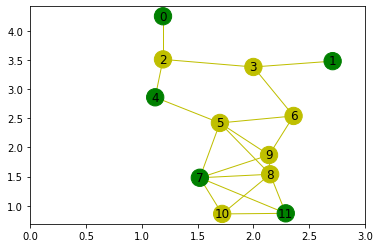

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -9.38779109765203


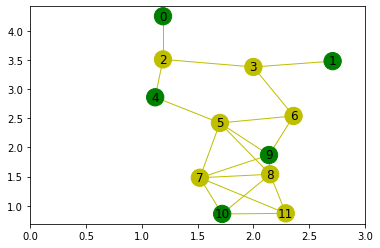

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -9.347659938844766


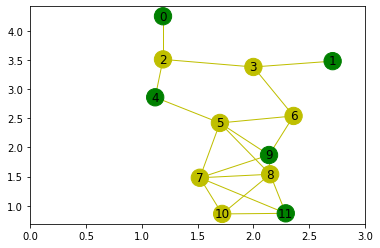

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -9.29798031517302


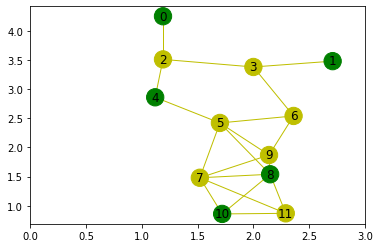

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -9.114528761922696


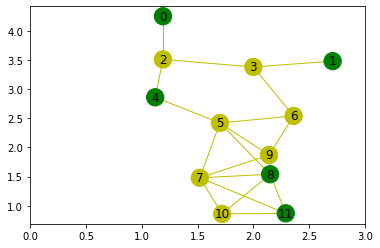

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -9.102367002934617


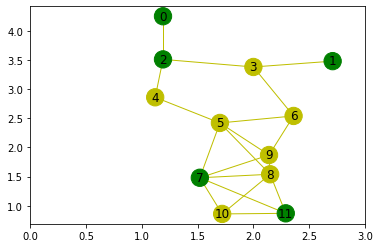

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0} -8.962071192475321


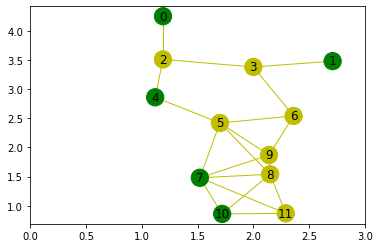

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.947363472296376


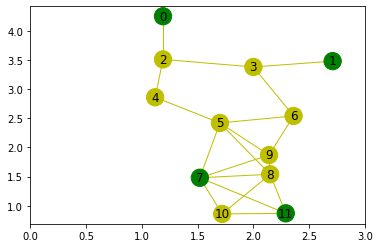

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1} -8.94116261480211


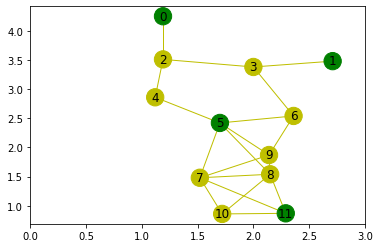

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.915583500291294


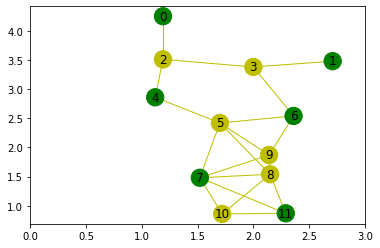

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.893359243200246


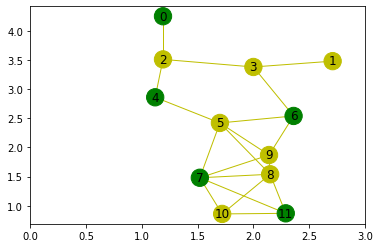

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.680414956798671


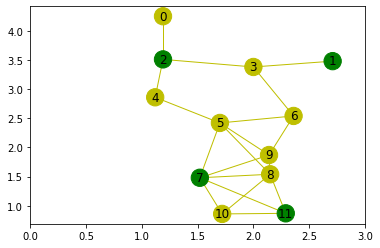

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.680385774554859


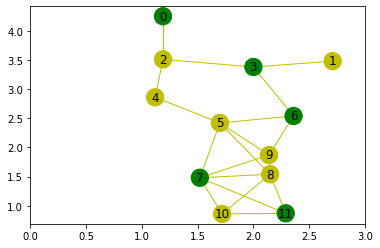

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0} -8.668310246557304


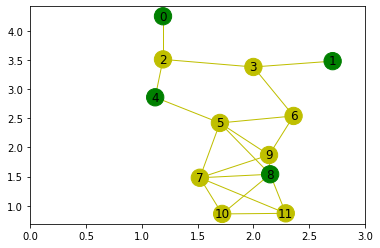

{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -8.629778391182345


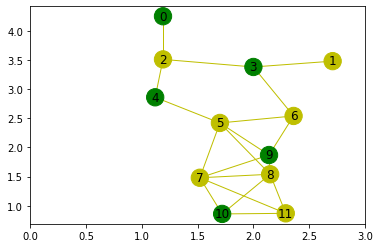

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -8.625357199240986


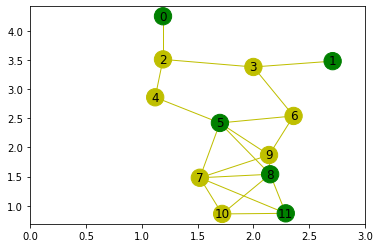

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -8.62463209781142


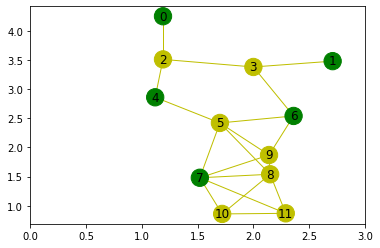

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -8.624483518112008


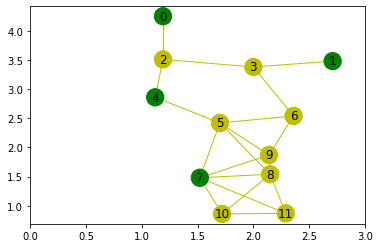

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0} -8.604001278074549


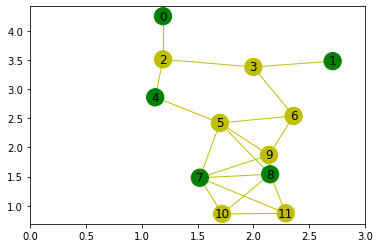

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.594901825958216


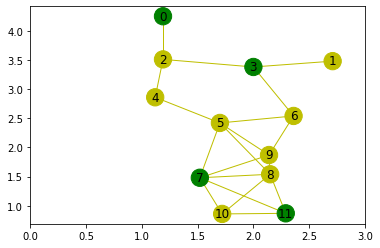

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -8.584922934702096


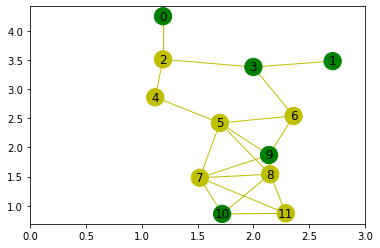

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0} -8.579977938697807


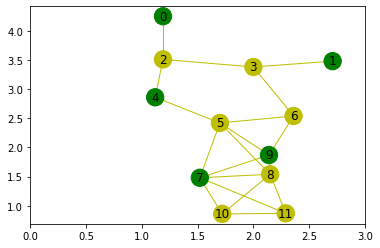

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -8.51223923114813


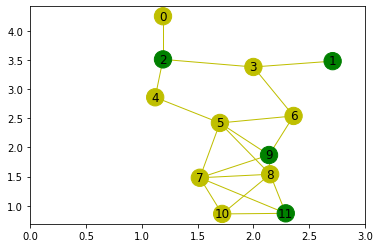

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -8.506606310612492


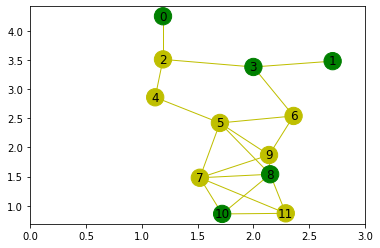

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -8.50261560127827


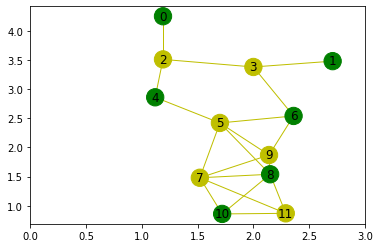

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -8.497692118888814


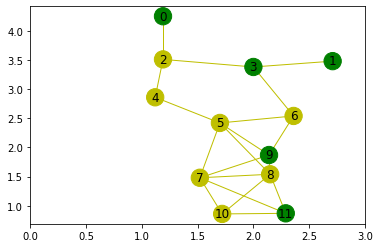

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1} -8.472025361720572


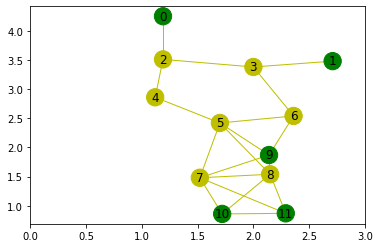

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -8.443045647781274


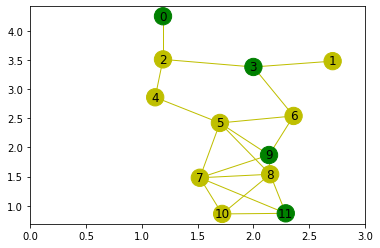

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0} -8.429394642204867


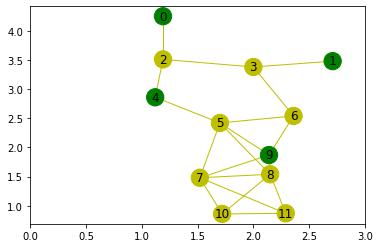

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -8.414208961525642


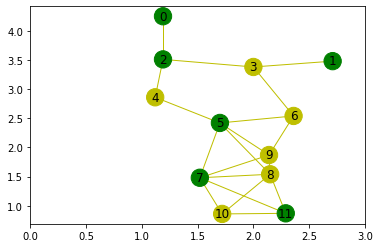

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0} -8.40597707281225


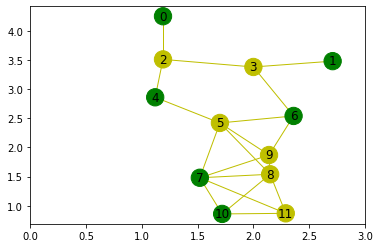

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1} -8.39473563760197


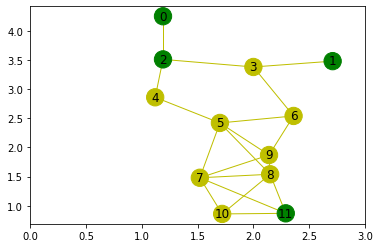

{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0} -8.372575948784196


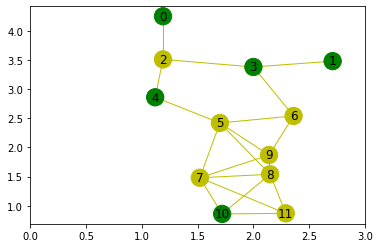

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -8.32310958893448


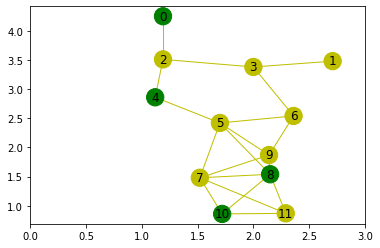

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -8.320457776443137


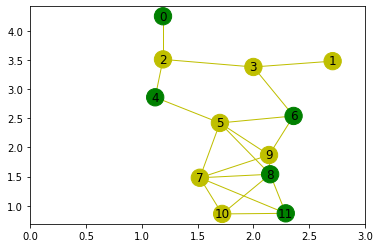

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0} -8.283951201910089


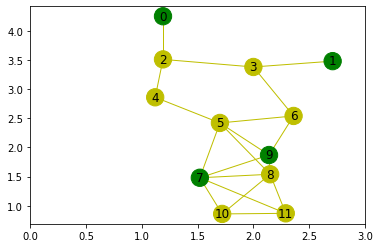

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0} -8.250063742069202


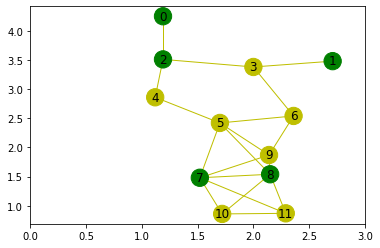

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1} -8.244810035551327


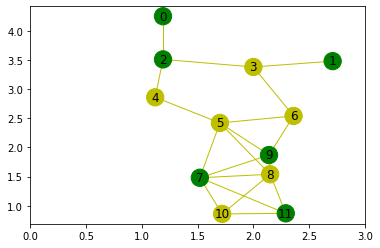

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -8.230830367396408


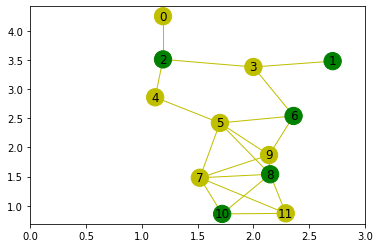

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1} -8.19105348219257


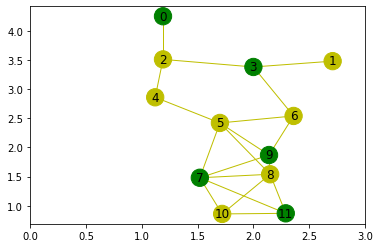

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -8.131145779273517


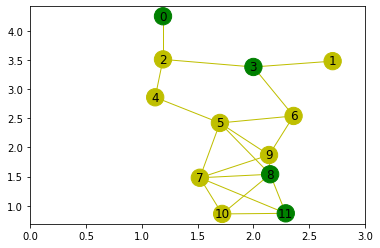

{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1} -8.06316054819471


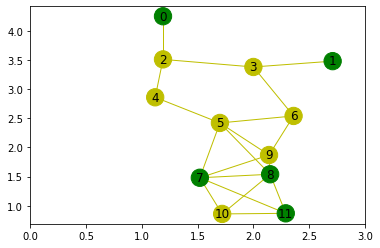

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1} -8.032246596321366


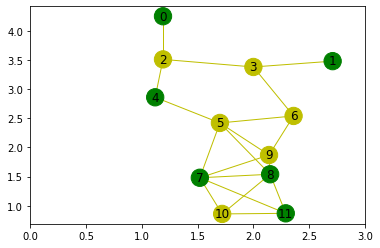

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -8.01312438010111


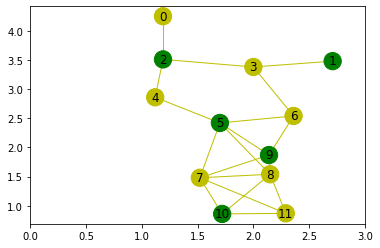

{0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -7.9966474864840915


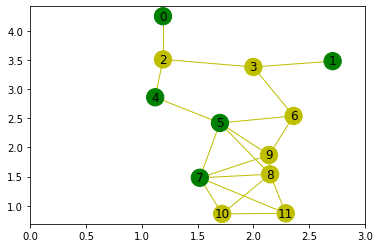

{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 0} -7.975134782932853


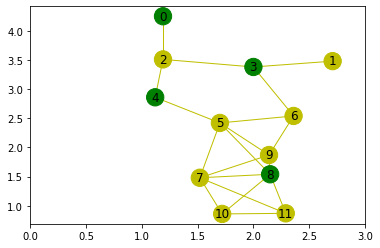

{0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -7.933559608029865


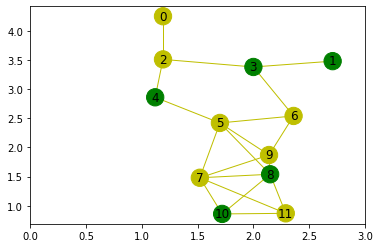

{0: 1, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -7.899931471043065


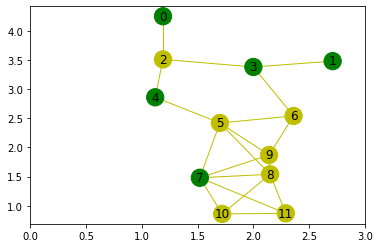

{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1} -7.882936382304935


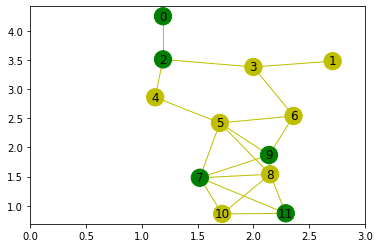

{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0} -7.880513369677132


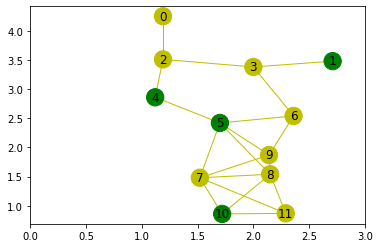

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -7.871223868539813


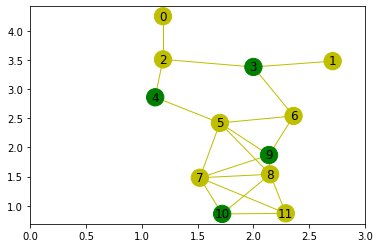

{0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0} -7.870937352104658


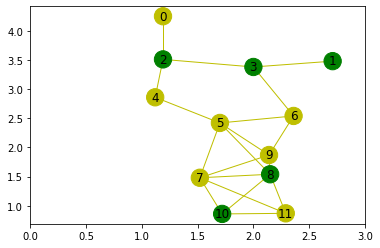

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -7.84986502541107


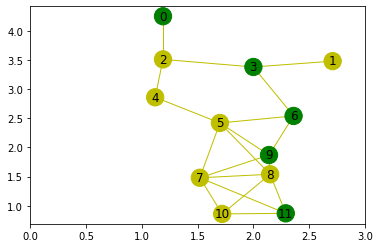

{0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -7.843388531864365


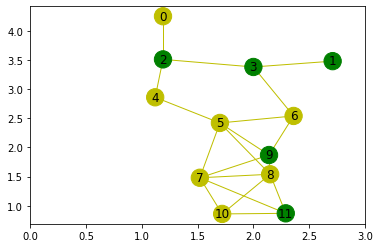

{0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 1} -7.843261468588863


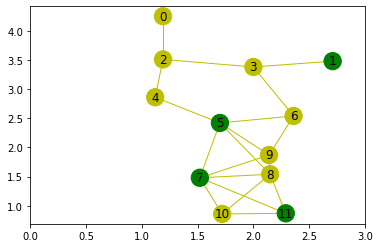

{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0} -7.830233429135865


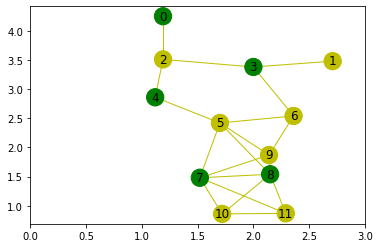

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0} -7.820325525372692


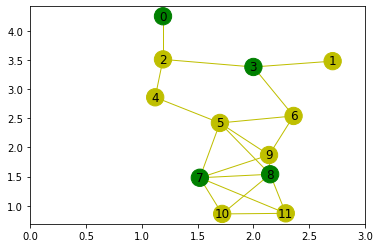

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1} -7.816008552122982


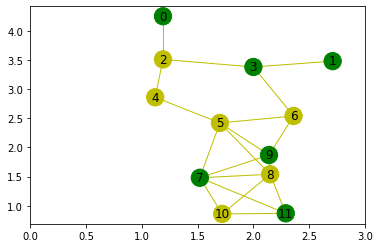

{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1} -7.781076415295309


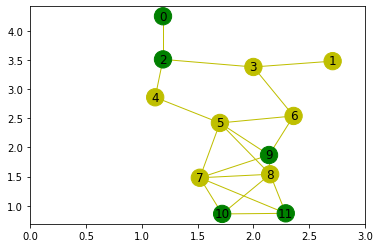

{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1} -7.768758401473298


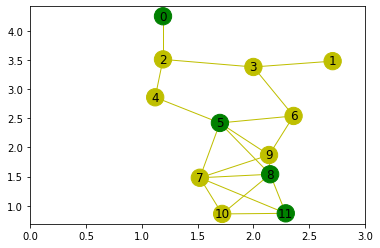

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0} -7.768021058722299


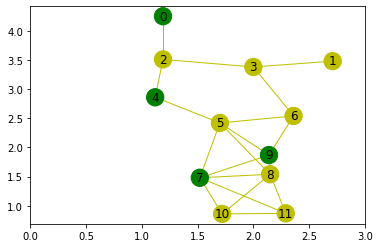

{0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -7.724558770434497


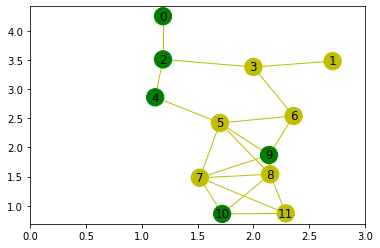

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1} -7.664261348709117


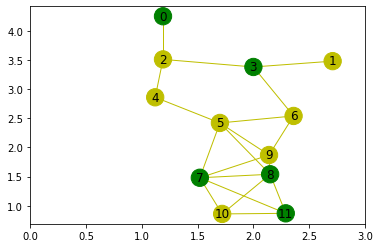

{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 1} -7.5615742562152235


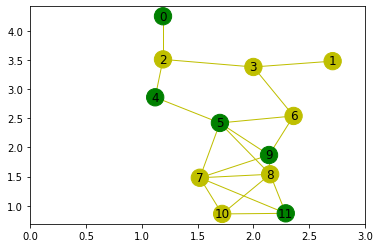

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1} -7.473349954044018


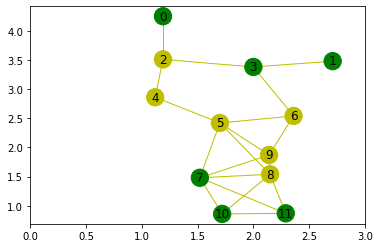

{0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0} -7.40506513796883


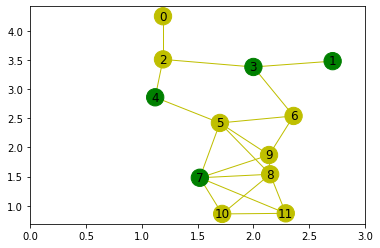

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 0} -7.356536934464216


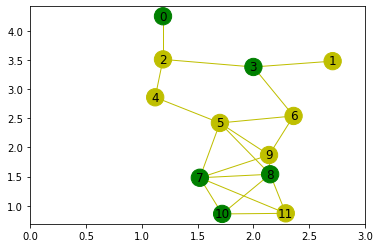

{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1} -7.309710928015192


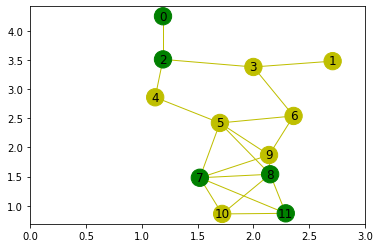

{0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0} -7.135548008874334


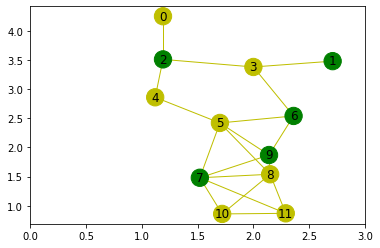

{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0} -7.027389163040613


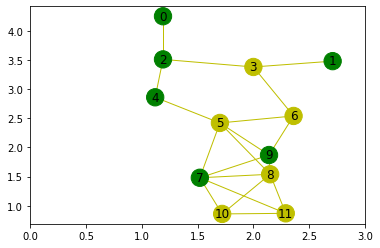

{0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0} -6.879722749816883


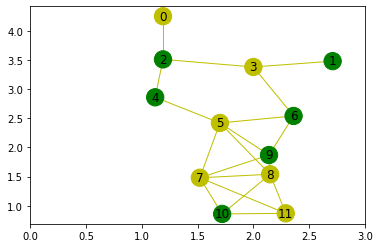

{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1} -6.761641779950332


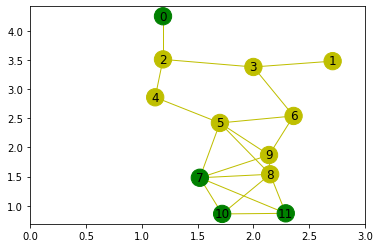

{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1} -6.590248724317188


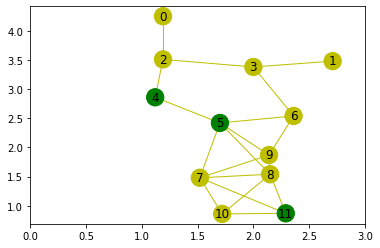

In [51]:
for sample in response.data():
    print(sample.sample, sample.energy)
    occupations = [sample.sample[sol] for sol in (sample.sample)]
    make_plot(udmis, graph, occupations)

## B. Additional Challenges (b) Repeated runs on Microsoft QIO

#### Run on Microsoft Quantum Inspired Optimizer QIO

In [ ]:
#Inital steps to install azure quantum
# conda create --name azure
# conda activate azure

# ensure python is installed
# ensure jupyter notebook is installed

# pip install azure-quantum


In [ ]:
# set up service in Azure Quantum
# portal.azure.com
# create a quantum workspace
# you will need the Resource ID in the next step

In [15]:
from azure.quantum import Workspace
import pandas as pd
from typing import List
from azure.quantum.optimization import Problem, ProblemType, Term

In [17]:
workspace = Workspace (
  subscription_id = "[subscription id]",
  resource_group = "[resource group]",
  name = "[name]",
  location = "westus"
)

In [18]:

workspace.login()

<ipython-input-18-ed9b496f8d91>:5: DeprecationWarning: Call to deprecated method login. (This method is deprecated and no longer necessary to be called) -- Deprecated since version 0.17.2105.
  workspace.login()


In [21]:
terms: List[Term] = []

Q=np.zeros([udmis.num_vertices, udmis.num_vertices])
for i in range(udmis.num_vertices):
    for j in range(udmis.num_vertices):
        if i!=j:
            if udmis.edges[i,j]==True:
                Q[i,j]=1
        else:
            Q[i,i]=-1
print(Q)

[[-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1. -1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1. -1.]]


In [22]:
    
for i in range(udmis.num_vertices):
    for j in range(udmis.num_vertices):
        
        terms.append(
            Term(
                w = float(Q[i][j]),
                indices = [i, j]
            )
        )
print(terms)

[{'c': -1.0, 'ids': [0, 0]}, {'c': 0.0, 'ids': [0, 1]}, {'c': 1.0, 'ids': [0, 2]}, {'c': 0.0, 'ids': [0, 3]}, {'c': 0.0, 'ids': [0, 4]}, {'c': 0.0, 'ids': [0, 5]}, {'c': 0.0, 'ids': [0, 6]}, {'c': 0.0, 'ids': [0, 7]}, {'c': 0.0, 'ids': [0, 8]}, {'c': 0.0, 'ids': [0, 9]}, {'c': 0.0, 'ids': [0, 10]}, {'c': 0.0, 'ids': [1, 0]}, {'c': -1.0, 'ids': [1, 1]}, {'c': 0.0, 'ids': [1, 2]}, {'c': 1.0, 'ids': [1, 3]}, {'c': 0.0, 'ids': [1, 4]}, {'c': 0.0, 'ids': [1, 5]}, {'c': 0.0, 'ids': [1, 6]}, {'c': 0.0, 'ids': [1, 7]}, {'c': 0.0, 'ids': [1, 8]}, {'c': 0.0, 'ids': [1, 9]}, {'c': 0.0, 'ids': [1, 10]}, {'c': 1.0, 'ids': [2, 0]}, {'c': 0.0, 'ids': [2, 1]}, {'c': -1.0, 'ids': [2, 2]}, {'c': 1.0, 'ids': [2, 3]}, {'c': 1.0, 'ids': [2, 4]}, {'c': 0.0, 'ids': [2, 5]}, {'c': 0.0, 'ids': [2, 6]}, {'c': 0.0, 'ids': [2, 7]}, {'c': 0.0, 'ids': [2, 8]}, {'c': 0.0, 'ids': [2, 9]}, {'c': 0.0, 'ids': [2, 10]}, {'c': 0.0, 'ids': [3, 0]}, {'c': 1.0, 'ids': [3, 1]}, {'c': 1.0, 'ids': [3, 2]}, {'c': -1.0, 'ids': [3

In [23]:
problem = Problem(name="UD-MIS", problem_type=ProblemType.pubo, terms=terms)

In [29]:
solutions=[[]]

In [42]:
from azure.quantum.optimization import ParallelTempering

# Instantiate a solver instance to solve the problem
solver = ParallelTempering(workspace, timeout=100) # timeout in seconds

# Optimize the problem
result = solver.optimize(problem)

In [43]:
print(result)

{'version': '1.0', 'configuration': {'0': 1, '1': 0, '2': 0, '3': 1, '4': 1, '5': 0, '6': 0, '7': 0, '8': 1, '9': 1, '10': 0}, 'cost': -5.0, 'parameters': {'all_betas': [0.09090909090909091, 0.269196957194828, 0.7971370193924947, 2.360455460965956, 0.09090909090909091, 0.14728087348531446, 0.23860821264056922, 0.3865666857631996, 0.6262726705347982, 1.014617845519802, 1.6437718279613873, 2.6630576569597566, 4.314392036446666, 0.09090909090909091, 0.12396839573413894, 0.16904979454985683, 0.23052515012484687, 0.31435616341083683, 0.4286725219389829, 0.5845602932409151, 0.7971370193924947, 1.0870177722181884, 1.482314342920251, 2.021361441720806, 2.756434286418719, 3.758818100772951, 5.125721147901922, 0.09090909090909091, 0.11425169395108473, 0.14358794527761562, 0.18045682576815564, 0.2267924783195229, 0.2850256730570716, 0.3582113256295033, 0.45018875820197796, 0.565783110445424, 0.7110584665503367, 0.8936359773180034, 1.1230936660263653, 1.4114688919017064, 1.7738898304493347, 2.2293

In [44]:
solution=[]
for i in range(udmis.num_vertices):
    if result['configuration'][str(i)]==1:
        solution.append(i)
print(solution, result['cost'])

[0, 3, 4, 8, 9] -5.0


In [45]:
solutions.append(solution)


In [46]:
print(solutions)

[[], [0, 3, 4, 8, 9], [0, 3, 4, 8, 9], [0, 3, 4, 8, 9], [0, 3, 4, 8, 9]]
